In [ ]:
from keras.models import Model
from keras.layers import Input, Conv2D, BatchNormalization, Activation, Add
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.losses import MeanSquaredError
import tensorflow as tf
import matplotlib.pyplot as plt
from keras.regularizers import l2
from sklearn.model_selection import train_test_split

In [ ]:
def plot(x,y):
  no = x.shape[0]
  print(no)
  plt.figure(figsize=(2*no, 4))
  for i in range(no):
    # display original
    ax = plt.subplot(2, no, i + 1)
    plt.imshow(x[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, no, i + 1 + no)
    plt.imshow(y[i])
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  plt.show()

def generator(dataset,batchsize,moves=10):
  while True:
    rand = np.random.randint(dataset.shape[0],size=batchsize)
    y_truth = dataset[rand]
    blurred = np.copy(y_truth)
    moving = tf.expand_dims(y_truth,axis=-1)

    for i in range(moves):
      #RandomTranslation requires a channel axis
      moving = layers.RandomTranslation(0.07,0.07,fill_mode='constant',interpolation='bilinear')(moving)
      blurred = blurred + tf.squeeze(moving)
    blurred = blurred/(moves+1)
    yield(blurred,y_truth)

def residual_block(x, filters, kernel_size=3, strides=1):
  """
  Residual block for the deblurring model.
  """
  y = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(x)
  y = BatchNormalization()(y)
  y = Activation('relu')(y)
  y = Conv2D(filters, kernel_size=kernel_size, strides=strides, padding='same')(y)
  y = BatchNormalization()(y)
  return Add()([x, y])

def build_deblur_model(input_shape):
    """
    Build a deblurring model based on ResNet blocks.
    """
    inputs = Input(shape=input_shape)

    # Encoder
    x = Conv2D(64, kernel_size=3, strides=1, padding='same', activation='relu')(inputs)

    # Residual blocks
    for _ in range(9):  # You can adjust the number of residual blocks
        x = residual_block(x, filters=64, kernel_size=3)

    # Decoder
    x = Conv2D(1, kernel_size=3, strides=1, padding='same', activation='sigmoid')(x)

    model = Model(inputs=inputs, outputs=x)
    return model



In [ ]:
#definizione di training e valid set
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = (x_train/255.).astype(np.float32)
x_test = (x_test/255.).astype(np.float32)

x_train, x_valid = train_test_split(x_train, test_size=0.2, random_state=42)


#Costruiamo il modello consapevoli della size delle immagini
input_shape = (28, 28, 1)
deblur_model = build_deblur_model(input_shape)

# Compile the model
deblur_model.compile(optimizer=Adam(learning_rate=0.0002, beta_1=0.5), loss='mse')

# Print the model summary
deblur_model.summary()

# Fase di training
batchsize = 64
epochs = 100
deblur_model.fit(generator(x_train, batchsize), steps_per_epoch=len(x_train) // (batchsize), epochs = epochs)

11490434/11490434 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 28, 28, 1)]          0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 28, 28, 64)           640       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 28, 28, 64)           36928     ['conv2d[0][0]']              
                                                                                                  
 batch_normalization (Batch  (None, 28, 28, 64)           256       ['conv2d_1[0][0]']            
 Normalization)              

313/313 [==============================] - 3s 11ms/step
MSE Mean: 0.00164605095051229, MSE Std: 1.8304654076928273e-05
1/1 [==============================] - 0s 114ms/step
10


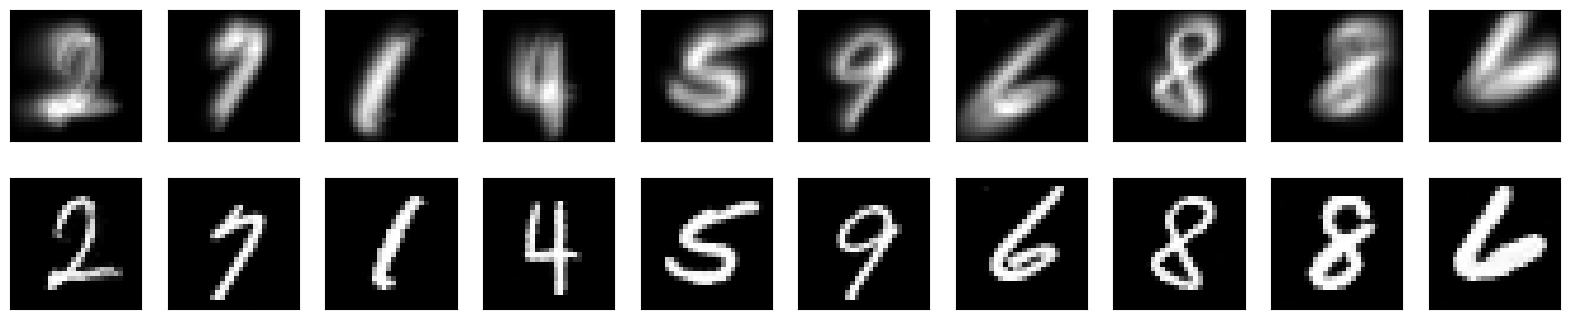

10


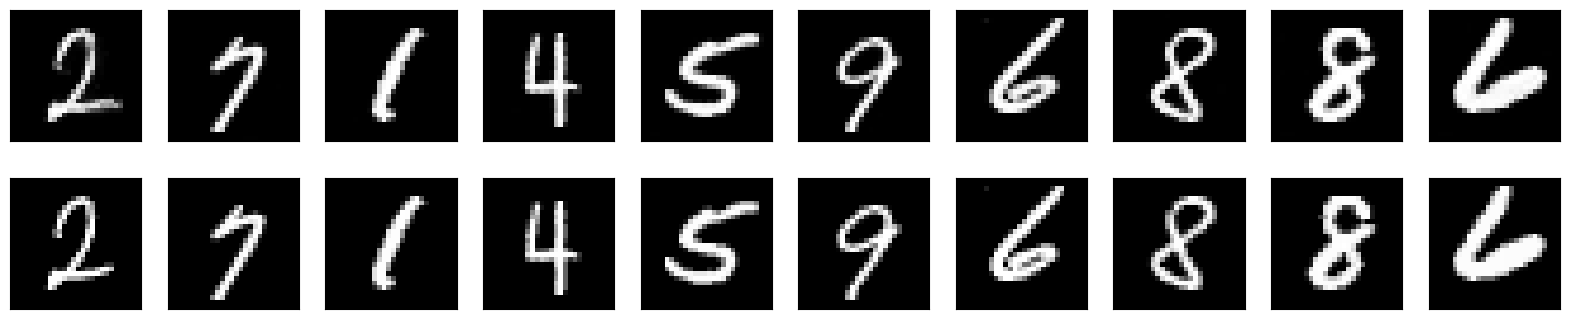

In [ ]:
#Evaluation of the model

mse_values = []
for i in range(10):
    blurred_images, ground_truth_images = next(generator(x_valid, 10000))
    deblurred_images = deblur_model.predict(blurred_images)
    deblurred_images = np.squeeze(deblurred_images)
    mse = np.mean((deblurred_images - ground_truth_images)**2)
    mse_values.append(mse)

mse_mean = np.mean(mse_values)
mse_std = np.std(mse_values)

print(f'MSE Mean: {mse_mean}, MSE Std: {mse_std}')

blurred_images, ground_truth_images = next(generator(x_valid, 10))
deblurred_images = deblur_model.predict(blurred_images).squeeze()

plot(blurred_images, deblurred_images)
plot(deblurred_images, ground_truth_images)

#**Descrizione modello**
Nello sviluppo di questo progetto ho testato diverse archittetture di modelli, iniziando da un autoencoder, successivamente una U-Net, una GAN e terminando con questa CNN. I test iniziali non avevano prodotto risultati eccezionali, probabilmente per una mancata corretta implementazione delle architetture che avevo ricercato, tuttavia quest'ultima ha dato i riscontri migliori. Il fulcro del modello sono i blocchi residuali, ispirati a quelli che compongono la ResNet. Questa strategia consente di creare reti più profonde, ovviando al problema del vanishing gradient (che rallenta il training) o dell'exploding gradient (che genera molti parametri e in generale valori poco gestibili).

Come funzione di attivazione ho scelto ReLU per l'encoder e i blocchi residuali, in quanto è una funzione di attivazione computazionalmente efficiente e che contribuisce a mitigare il problema del vanishing gradient durante il processo di apprendimento.

Come funzione di attivazione del decoder ho scelto la funzione sigmoide, in quanto il decoder produce l'immagine di output, e una funzione con valori 0 e 1 è preferibile come indice della probabilità che quel pixel sia presente o meno.

Infine, ho utilizzato l'ottimizzatore Adam per la sua gestione del learning rate e ulteriori ottimizzazioni del processo di training.


#**Motivazione iperparametri**
**kernel_size = 3**. Ho optato come 3 per la dimensione del kernel in quanto un kernel piccolo è preferibile in una rete con così tanti parametri, produce lo stesso una rete abbastanza complessa e mitiga il problema del vanishing gradient.

**Blocchi residuali = 9**. La rete è composta da 9 blocchi residuali, numero scelto sperimentalmente, cercando un buon compromesso tra numero di parametri e complessità della rete.

**Batchsize = 64**. Anche questo parametro è stato scelto sperimentalmente, dopo aver provato 128 e 32 come valori. 64 E' risultato essere il valore migliore.

**Epoche = 100**. Il numero di epoche è stato scelto limitatamente al tempo consentito per l'utilizzo della GPU di Google Colab. Tuttavia sembra risultare ottimale per risultati ed immagini prodotte.

Infine, i parametri utilizzati per l'ottimizzatore Adam, quali **learning_rate=0.0002 e beta_1=0.5** sono anch'essi risultati i più efficienti a fronte di diversi test.